In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

In [9]:
df = pd.read_excel(r"C:\Users\thibc\OneDrive\Documents\Dev\Cross-Assets-Solutions\datas\Stoxx600_sectors_prices_cleen.xlsx").set_index("Date")
df.head()

,Technology,Telecommunications,Health Care,Financials,Real Estate,Consumer Discretionary,Consumer Staples,Industrials,Basic Materials,Energy,Utilities
Date,,,,,,,,,,,
2011-05-09,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2011-05-10,101.489142,100.071333,100.004909,101.279328,100.988875,101.137178,100.439376,101.182716,101.431208,100.735358,101.038121
2011-05-11,101.636641,101.060745,101.067694,101.564491,101.165460,102.068410,101.224642,101.473118,100.297198,100.446468,101.958113
2011-05-12,101.139950,100.175350,101.735310,100.800823,100.688681,101.477436,101.439656,100.548226,98.737624,98.756894,101.156045
2011-05-13,100.711645,99.292570,102.317903,99.769005,100.476779,101.289398,101.570534,100.276834,98.262015,98.100324,100.475121


<Axes: >

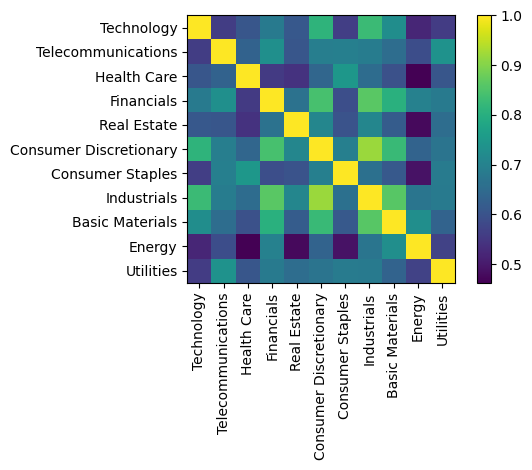

In [10]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(df, frequency=252)
plotting.plot_covariance(sample_cov, plot_correlation=True)

<Axes: >

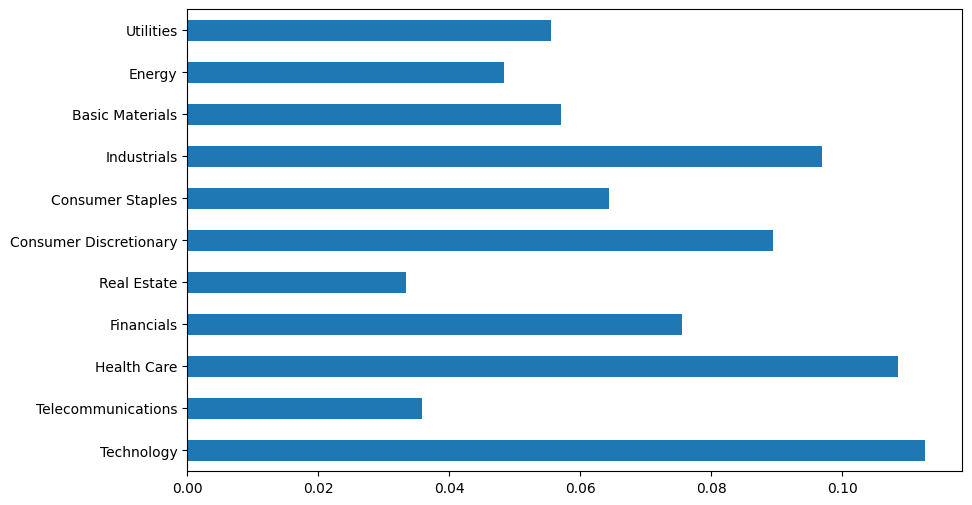

In [11]:
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(df, frequency=252)
mu.plot.barh(figsize=(10,6))

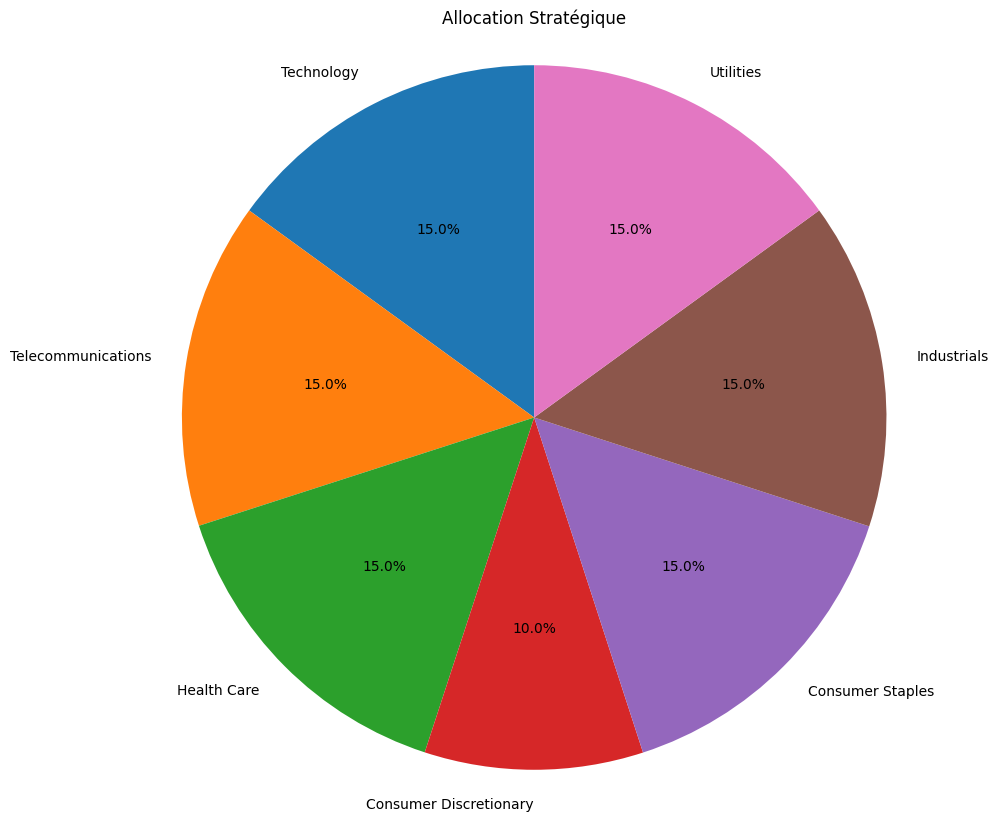

OrderedDict([('Technology', 0.15),
             ('Telecommunications', 0.14972),
             ('Health Care', 0.15),
             ('Financials', 0.0),
             ('Real Estate', 0.0),
             ('Consumer Discretionary', 0.10028),
             ('Consumer Staples', 0.15),
             ('Industrials', 0.15),
             ('Basic Materials', 0.0),
             ('Energy', 0.0),
             ('Utilities', 0.15)])

In [12]:
from pypfopt import EfficientFrontier

ef = EfficientFrontier(mu, sample_cov)

ef.add_constraint(lambda x: x <= 0.15)

ef.efficient_risk(target_volatility=0.15)
# ef.max_sharpe()
weights = ef.clean_weights()

# Filtrer les secteurs avec un poids > 0
filtered_sector_allocation = {k: v for k, v in weights.items() if v > 0}

secteurs = list(filtered_sector_allocation.keys())
poids = list(filtered_sector_allocation.values())

# Création du graphique de répartition sectorielle
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(poids, labels=secteurs, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Assure que le graphique est circulaire
plt.title('Allocation Stratégique')
plt.show()
weights

Test Black Litterman

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

market_prior = pd.Series(weights)

viewdict = {
    "Technology": 0.25,
    "Telecommunications": 0.30,
    "Health Care": 0.05,
    "Financials": 0.0,
    "Real Estate": 0.20,
    "Consumer Discretionary": -0.05,
    "Consumer Staples": 0.15,
    "Industrials": 0.10,
    "Basic Materials": 0.20,
    "Energy": 0.0,
    "Utilities": 0.20
}
views = pd.Series(viewdict)
views = views[market_prior > 0]
views = views / views.sum()

bl = BlackLittermanModel(sample_cov, pi=market_prior, absolute_views=views)
ret_bl = bl.bl_returns()
print("Returns")
print(ret_bl)
print("-----")
print("BL weights")
w_bl = pd.Series(bl.bl_weights())
print(w_bl)
print("-----")
print("Prior weights")
print(market_prior)

Technology                0.149163
Telecommunications        0.186218
Health Care               0.124122
Financials               -0.002404
Real Estate              -0.002701
Consumer Discretionary    0.075329
Consumer Staples          0.144682
Industrials               0.132577
Basic Materials          -0.012474
Energy                    0.001972
Utilities                 0.169574
dtype: float64
-----
Technology                0.298199
Telecommunications        1.318409
Health Care              -0.308856
Financials               -1.321447
Real Estate              -0.909375
Consumer Discretionary   -0.698349
Consumer Staples          0.791468
Industrials               2.591584
Basic Materials          -1.273254
Energy                   -0.135177
Utilities                 0.646799
dtype: float64


In [ ]:
ret_bl = ret_bl / ret_bl.sum()
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(views)],
             index=["Prior", "Posterior", "Views"]).T
rets_df["Posterior"] = rets_df["Posterior"] / rets_df["Posterior"].sum()

<Axes: >

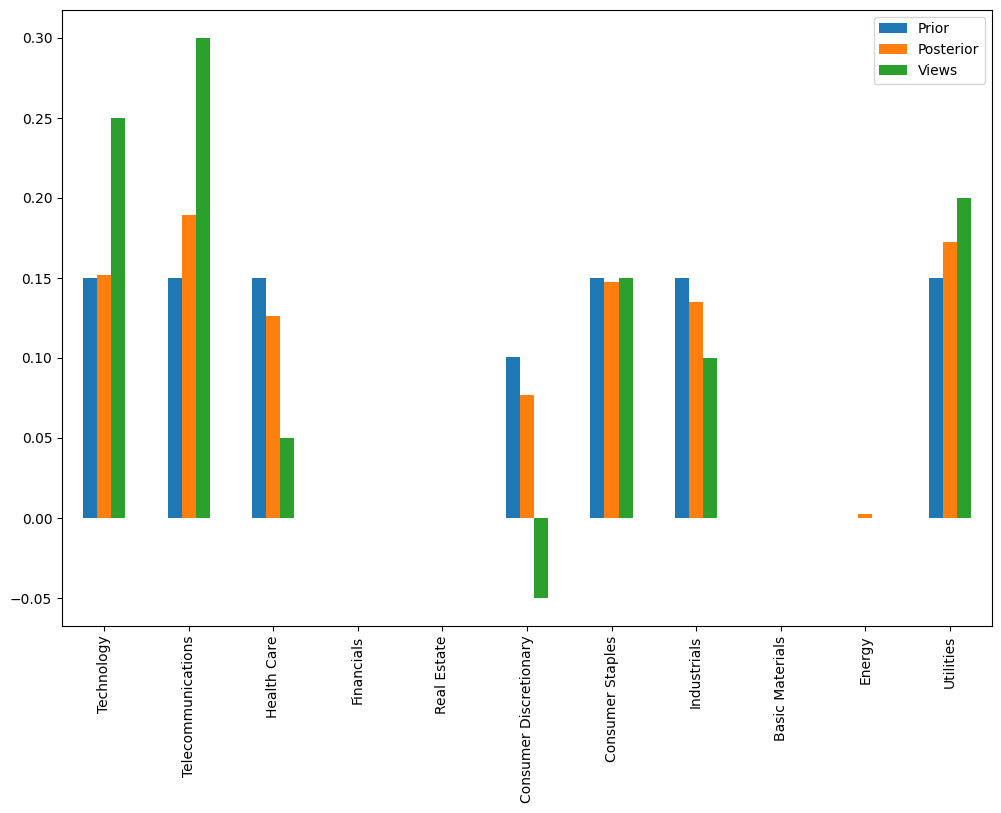

In [15]:
rets_df.plot.bar(figsize=(12,8))

------------------------

In [ ]:
print("Perf portefeuille optimisé :")
ef.portfolio_performance(verbose=True);

Perf portefeuille optimisé :
Expected annual return: 7.5%
Annual volatility: 15.0%
Sharpe Ratio: 0.50


In [ ]:
import yfinance as yf

stoxx600 = yf.Ticker("^STOXX")
data = stoxx600.history(period="5y", interval="1d")
data["returns"] = data["Close"].pct_change()


mean_daily_return = data["returns"].mean()
annual_return = (1 + mean_daily_return) ** 252 - 1
annual_volatility = data["returns"].std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility

print(f"Perf STOXX600 :\nExpected annual return: {annual_return:.2%}\nAnnual volatility: {annual_volatility:.2%}\nSharpe Ratio: {sharpe_ratio:.2f}")



Perf STOXX600 :
Expected annual return: 7.74%
Annual volatility: 17.55%
Sharpe Ratio: 0.44


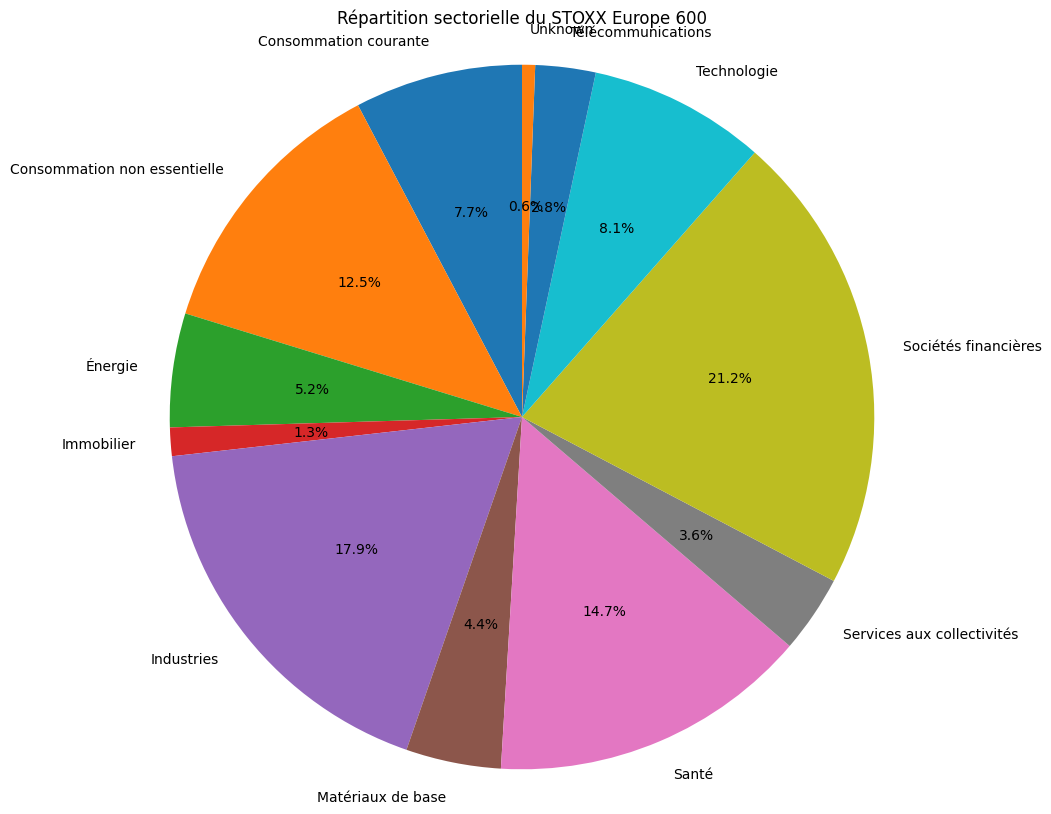

In [ ]:
# Données de répartition sectorielle
secteurs = ["Consommation courante", "Consommation non essentielle", "Énergie", "Immobilier", "Industries", "Matériaux de base", "Santé", "Services aux collectivités", "Sociétés financières", "Technologie", "Télécommunications", "Unknown"]
poids = [0.077088013, 0.125418618, 0.052218956, 0.013057364, 0.179035648, 0.043628194, 0.146921617, 0.035596528, 0.212169866, 0.081237039, 0.027647824, 0.005980304]

# Création du graphique
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(poids, labels=secteurs, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Assure que le graphique est circulaire

# Titre du graphique
plt.title('Répartition sectorielle du STOXX Europe 600')

# Affichage du graphique
plt.show()
